In [1]:
import pandas as pd
import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

df_eventos = pd.read_excel('Relatorios/evento_adverso.xlsx')

data_eapv = df_eventos
data_eapv.shape

(34976, 110)

In [2]:
#### BANCO VACINADOS #### 
#(extrair do painel https://vacina.saude.rs.gov.br - sobre - base de dados - aplicadas)
df_vacinados = pd.read_csv('Arquivos/SESRS_VAC_APLICACAO_08_02_2022-08_54.csv', sep=';', encoding='cp1252')

# tratar nomes de vacina
df_vacinados.loc[df_vacinados['TP_VACINA'].str.contains('AstraZeneca'), 'TP_VACINA'] = 'Astrazeneca'
df_vacinados['TP_VACINA'].replace('CoronaVac', 'Coronavac', inplace=True)

# filtrar data até 08-02-2022 - CONFORME BOLETIM
# df_vacinados = df_vacinados[df_vacinados['DATA']<= '2021-02-08']
total_aplicadas = df_vacinados['COUNT'].sum()
print(f'Total vacinados: {total_aplicadas}')

Total vacinados: 20552390


In [3]:
#### CALCULOS DE INCIDENCIA ####

# total de vacinas aplicadas até 08-02-2022
total_aplicadas = df_vacinados['COUNT'].sum()

# total de EAPV - sem os erros de imunização e os covid
total_eapv = len(data_eapv)

# Incidência de EVENTOS ADVERSOS por 1000 doses aplicadas
tx_eapvpor1000ds = round((total_eapv/total_aplicadas*1000),2)
print(f'Taxa de incidência de eventos adversos por 1000 doses no RS: {tx_eapvpor1000ds}') #n eventos

Taxa de incidência de eventos adversos por 1000 doses no RS: 1.7


In [4]:
## NÚMERO DE NOTIFICAÇÕES ##
# Agora não temos mais o dataset por pessoa como era antes, e sim por evento/vacina, o que dá um n bem maior
# Verificar incidência de EAPV pelo número da notificação único

notificacoes_eapv = data_eapv['NUMERO DA NOTIFICACAO'].nunique()
print(f'Temos {notificacoes_eapv} notificações de EAPV no período analisado')

# O número de notificações não corresponde ao número de indivíduos, 
# pois um indivíduo pode ter tido mais de uma notificação de EAPV (para doses ou vacinas diferentes)')
# Incidência de Notificações por 1000ds

tx_notif_por1000ds = round((notificacoes_eapv/total_aplicadas*1000),2)
print(f'Taxa geral de incidência de Notificações de EAPV por 1000 doses no RS: {tx_notif_por1000ds}') 

Temos 11268 notificações de EAPV no período analisado
Taxa geral de incidência de Notificações de EAPV por 1000 doses no RS: 0.55


In [5]:
## REFAZER ESTES CÁLCULOS POR NOTIFICAÇÃO ÚNICA
data_eapv = data_eapv.drop_duplicates(subset=['NUMERO DA NOTIFICACAO'])
data_eapv['VACINA'] = data_eapv['VACINA'].str.replace('Butantan', 'Coronavac')

In [6]:
## DATASETS
# O data_eapv está com as notificações unicas
# o df_eventos está com todos os eventos separados por vacina

# Total aplicadas - vacina por sexo

In [7]:
df_apl_por_sexo = df_vacinados[['SEXO','TP_VACINA', 'COUNT']]
df_apl_por_sexo.rename(columns={'TP_VACINA' : 'VACINA'}, inplace=True)
df_apl_por_sexo = df_apl_por_sexo.groupby(by=['SEXO', 'VACINA']).sum()
df_apl_por_sexo.reset_index(inplace=True)
#print(df_apl_por_sexo.groupby(by=['SEXO', 'VACINA']).sum().sum())

# TOTAL EAPV POR VACINA POR SEXO
df_eapv_por_sexo = data_eapv[['SEXO', 'VACINA']]
df_eapv_por_sexo['eapv'] = 1
df_eapv_por_sexo = df_eapv_por_sexo.groupby(by=['SEXO', 'VACINA']).sum()
df_eapv_por_sexo.reset_index(inplace=True)

# Merge EAPV e aplicadas por sexo, vacina
df_eapv_apl_sexo_vac = pd.merge(df_apl_por_sexo, df_eapv_por_sexo, left_on=['SEXO', 'VACINA'], right_on=['SEXO', 'VACINA'],
                                how='left')

# Incidência de EAPV por sexo e por vacina (por mil doses aplicadas):
df_eapv_apl_sexo_vac['incidencia_1000ds'] = round((df_eapv_apl_sexo_vac['eapv']/df_eapv_apl_sexo_vac['COUNT']*1000),2)
df_eapv_apl_sexo_vac

,SEXO,VACINA,COUNT,eapv,incidencia_1000ds
0,Feminino,Astrazeneca,3792947,5377,1.42
1,Feminino,Coronavac,2610486,1715,0.66
2,Feminino,Janssen,203636,87,0.43
3,Feminino,Pfizer,4382889,1170,0.27
4,Masculino,Astrazeneca,3482543,1812,0.52
5,Masculino,Coronavac,2017694,539,0.27
6,Masculino,Janssen,241244,86,0.36
7,Masculino,Pfizer,3820951,482,0.13


In [8]:
# separando o DataFrame por sexo p/ o gráfico
feminino = df_eapv_apl_sexo_vac.loc[df_eapv_apl_sexo_vac['SEXO']=='Feminino']
masculino = df_eapv_apl_sexo_vac.loc[df_eapv_apl_sexo_vac['SEXO']=='Masculino']

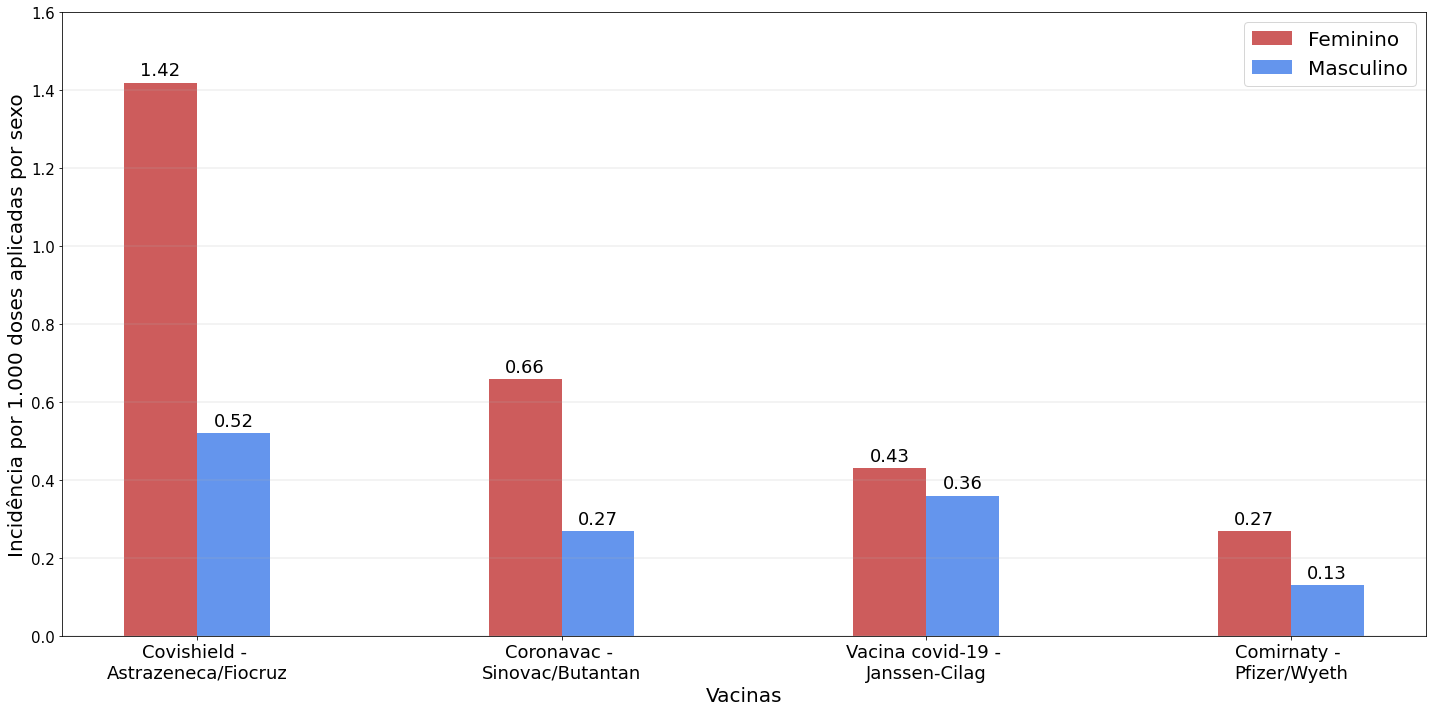

In [9]:
## GRAFICO ##
diameters = feminino['VACINA'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, feminino['incidencia_1000ds'], width=width, label='Feminino', align='center', color='indianred')
rects2 = ax.bar(x, masculino['incidencia_1000ds'], width=width, label='Masculino', align='center', color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência por 1.000 doses aplicadas por sexo', fontsize=20)
ax.set_xlabel('Vacinas', fontsize=20) # negrito -> weight='bold'
plt.xticks(x-width/2,('Covishield - \nAstrazeneca/Fiocruz','Coronavac - \nSinovac/Butantan','Vacina covid-19 - \nJanssen-Cilag','Comirnaty - \nPfizer/Wyeth'),fontsize=18)
plt.yticks(fontsize=15)
ax.legend(fontsize=20)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=18)


autolabel(rects1)
autolabel(rects2)

plt.ylim(0,1.60)
plt.grid(axis='y', linewidth=0.3)
fig.tight_layout()
plt.savefig('Graficos/Figura 2.png', dpi=(800), bbox_inches='tight')
plt.show()

# Incidencia de EAPV geral

POR VACINA

In [10]:
# Incidencia de EAPV geral POR VACINA (por mil doses):
df_eapv_apl_vac = df_eapv_apl_sexo_vac[['VACINA', 'COUNT', 'eapv']]
df_eapv_apl_vac = df_eapv_apl_vac.groupby(by=['VACINA']).sum()
df_eapv_apl_vac.reset_index(inplace=True)
df_eapv_apl_vac['incidencia_1000ds'] = round((df_eapv_apl_vac['eapv']/df_eapv_apl_vac['COUNT']*1000),2)
df_eapv_apl_vac

,VACINA,COUNT,eapv,incidencia_1000ds
0,Astrazeneca,7275490,7189,0.99
1,Coronavac,4628180,2254,0.49
2,Janssen,444880,173,0.39
3,Pfizer,8203840,1652,0.20


POR SEXO

In [11]:
# Incidencia de EAPV geral POR SEXO (por mil doses):
df_eapv_apl_sexo = df_eapv_apl_sexo_vac[['SEXO', 'COUNT', 'eapv']]
df_eapv_apl_sexo = df_eapv_apl_sexo.groupby(by=['SEXO']).sum()
df_eapv_apl_sexo.reset_index(inplace=True)
df_eapv_apl_sexo['incidencia_1000ds'] = round((df_eapv_apl_sexo['eapv']/df_eapv_apl_sexo['COUNT']*1000),2)
df_eapv_apl_sexo

,SEXO,COUNT,eapv,incidencia_1000ds
0,Feminino,10989958,8349,0.76
1,Masculino,9562432,2919,0.31


POR FAIXA ETARIA

In [12]:
# POR FAIXA ETARIA
# TOTAL APLICADAS POR FAIXA ETÁRIA
df_faixas_apl = df_vacinados[['FAIXAETARIA','TP_VACINA', 'COUNT']]
df_faixas_apl.rename(columns={'TP_VACINA' : 'VACINA'}, inplace=True)
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' a ', '-', x))
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' e mais', '+', x))
df_faixas_apl['FAIXAETARIA'].replace(['12-14', '15-17'], '12-17', inplace=True)
df_faixas_apl = df_faixas_apl.groupby(by=['FAIXAETARIA', 'VACINA']).sum()
df_faixas_apl.reset_index(inplace=True)

# TOTAL EAPV POR VACINA POR FAIXA ETARIA
df_faixas_eapv = data_eapv[['FAIXA ETARIA', 'VACINA']]
df_faixas_eapv['eapv'] = 1
df_faixas_eapv = df_faixas_eapv.groupby(by=['VACINA', 'FAIXA ETARIA']).sum()
df_faixas_eapv.reset_index(inplace=True)

# Merge EAPV e APLICADAS por faixa etária e por vacina
df_faixas_apl_eapv = pd.merge(df_faixas_apl, df_faixas_eapv, left_on=['FAIXAETARIA', 'VACINA'], right_on=['FAIXA ETARIA', 'VACINA'], how='outer')
df_faixas_apl_eapv = df_faixas_apl_eapv[['FAIXAETARIA', 'VACINA', 'COUNT', 'eapv']]
df_faixas_apl_eapv['eapv'].fillna(0, inplace=True)

# Incidência de EAPV por faixa etária e por vacina por 1000 doses
df_faixas_apl_eapv['incidencia_1000ds'] = round((df_faixas_apl_eapv['eapv']/df_faixas_apl_eapv['COUNT']*1000),2)

In [13]:
df_faixas_apl_eapv.loc[df_faixas_apl_eapv['FAIXAETARIA'].str.contains('', na=False), 'Nome Padrão'] = 'Erro de administração da vacina'

In [14]:
# Merge para pegar o total aplicadas por vacina
df_faixas_grafico = df_faixas_apl_eapv[['FAIXAETARIA', 'VACINA', 'COUNT']]
df_faixas_grafico = pd.merge(df_faixas_grafico, df_eapv_apl_vac[['VACINA', 'COUNT']], on='VACINA', how='outer')
df_faixas_grafico.rename(columns={'COUNT_x':'APL POR FAIXA', 'COUNT_y':'APL POR VACINA'}, inplace=True)
df_faixas_grafico

,FAIXAETARIA,VACINA,APL POR FAIXA,APL POR VACINA
0,05-11,Coronavac,66575.0,4628180
1,12-17,Coronavac,226.0,4628180
2,18-19,Coronavac,143726.0,4628180
3,20-24,Coronavac,339980.0,4628180
4,25-29,Coronavac,315879.0,4628180
...,...,...,...,...
56,60-64,Janssen,3005.0,444880
57,65-69,Janssen,1053.0,444880
58,70-74,Janssen,598.0,444880
59,75-79,Janssen,345.0,444880


In [15]:
# Porcentagem de vacinados por faixa etaria
df_faixas_grafico['% APLICADAS'] = ((df_faixas_grafico['APL POR FAIXA']/df_faixas_grafico['APL POR VACINA'])*100).round(2)
df_faixas_grafico

,FAIXAETARIA,VACINA,APL POR FAIXA,APL POR VACINA,% APLICADAS
0,05-11,Coronavac,66575.0,4628180,1.44
1,12-17,Coronavac,226.0,4628180,0.00
2,18-19,Coronavac,143726.0,4628180,3.11
3,20-24,Coronavac,339980.0,4628180,7.35
4,25-29,Coronavac,315879.0,4628180,6.83
...,...,...,...,...,...
56,60-64,Janssen,3005.0,444880,0.68
57,65-69,Janssen,1053.0,444880,0.24
58,70-74,Janssen,598.0,444880,0.13
59,75-79,Janssen,345.0,444880,0.08


In [16]:
# Retirando valores NaN
df_faixas_grafico = df_faixas_grafico[df_faixas_grafico['FAIXAETARIA'].notna()]

In [17]:
df_faixas_grafico[df_faixas_grafico['VACINA'] == 'Astrazeneca']

,FAIXAETARIA,VACINA,APL POR FAIXA,APL POR VACINA,% APLICADAS
32,18-19,Astrazeneca,98782.0,7275490,1.36
33,20-24,Astrazeneca,334710.0,7275490,4.60
34,25-29,Astrazeneca,447614.0,7275490,6.15
35,30-34,Astrazeneca,646899.0,7275490,8.89
36,35-39,Astrazeneca,729031.0,7275490,10.02
37,40-44,Astrazeneca,748910.0,7275490,10.29
38,45-49,Astrazeneca,679487.0,7275490,9.34
39,50-54,Astrazeneca,900182.0,7275490,12.37
40,55-59,Astrazeneca,1146546.0,7275490,15.76
41,60-64,Astrazeneca,976157.0,7275490,13.42


In [18]:
# Separando por vacina
pfizer = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Pfizer'].reset_index(drop=True)

astrazeneca = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Astrazeneca'].reset_index(drop=True)
astrazeneca.at[14]=['12-17', 'Astrazeneca', 0, astrazeneca['APL POR VACINA'][0], 0]
astrazeneca.at[15]=['05-11', 'Astrazeneca', 0, astrazeneca['APL POR VACINA'][0], 0]
astrazeneca = astrazeneca.sort_values('FAIXAETARIA').reset_index(drop=True)

coronavac = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Coronavac'].reset_index(drop=True)

janssen = df_faixas_grafico.loc[df_faixas_grafico['VACINA']=='Janssen'].reset_index(drop=True)
janssen.at[14]=['12-17', 'Janssen', 0, janssen['APL POR VACINA'][0], 0]
janssen.at[15]=['05-11', 'Janssen', 0, janssen['APL POR VACINA'][0], 0]
janssen = janssen.sort_values('FAIXAETARIA').reset_index(drop=True)

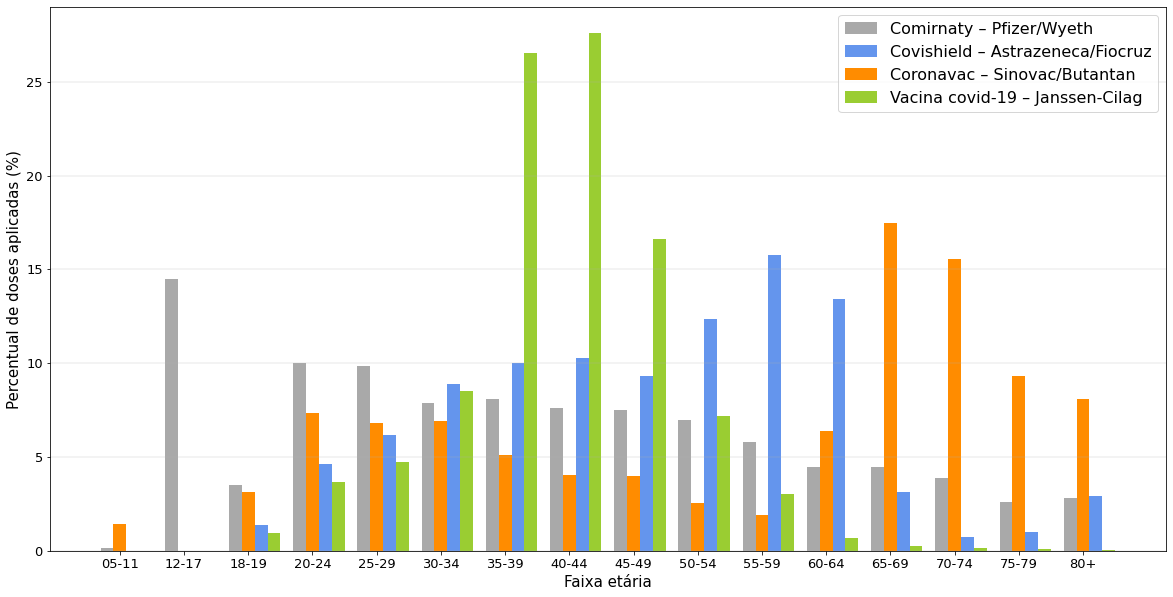

In [19]:
## GRÁFICO ##
fig, ax = plt.subplots(figsize=(20,10))
width = 0.2

x1 = np.arange(len(pfizer['FAIXAETARIA']))
x2 = np.arange(len(astrazeneca['FAIXAETARIA']))
x3 = np.arange(len(coronavac['FAIXAETARIA']))
x4 = np.arange(len(janssen['FAIXAETARIA']))

plt.bar(x1-0.2, pfizer['% APLICADAS'], width, label = 'Comirnaty – Pfizer/Wyeth', color='darkgray')
plt.bar(x2+0.2, astrazeneca['% APLICADAS'], width, label = 'Covishield – Astrazeneca/Fiocruz', color='cornflowerblue')
plt.bar(x3, coronavac['% APLICADAS'], width, label = 'Coronavac – Sinovac/Butantan', color='darkorange')
plt.bar(x4+0.4, janssen['% APLICADAS'], width, label = 'Vacina covid-19 – Janssen-Cilag', color='yellowgreen')

plt.xticks(np.arange(0,16,1), (df_faixas_grafico['FAIXAETARIA'].unique()), fontsize=13)
plt.yticks(fontsize=13)

plt.ylabel('Percentual de doses aplicadas (%)', fontsize=15)
plt.xlabel('Faixa etária', fontsize=15)

plt.grid(axis='y', linewidth=0.3)
plt.legend(fontsize=16)
plt.savefig('Graficos/Figura 7.png', dpi=(800), bbox_inches='tight')
plt.show()

POR GRAVIDADE, FAIXA ETARIA E VACINAS

In [20]:
# TOTAL APLICADAS POR FAIXA ETÁRIA
df_faixas_apl = df_vacinados[['FAIXAETARIA','TP_VACINA', 'COUNT']]
df_faixas_apl.rename(columns={'TP_VACINA' : 'VACINA'}, inplace=True)
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' a ', '-', x))
df_faixas_apl['FAIXAETARIA'] = df_faixas_apl['FAIXAETARIA'].map(lambda x: re.sub(r' e mais', '+', x))
df_faixas_apl['FAIXAETARIA'].replace(['12-14', '15-17'], '12-17', inplace=True)
df_faixas_apl = df_faixas_apl.groupby(by=['FAIXAETARIA', 'VACINA']).sum()
df_faixas_apl.reset_index(inplace=True)

# TOTAL EAPV POR VACINA POR FAIXA ETARIA, CLASSIFICAÇÃO DE GRAVIDADE
df_faixas_eapv = df_eventos[['FAIXA ETARIA', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']]
df_faixas_eapv['eapv'] = 1
df_faixas_eapv = df_faixas_eapv.groupby(by=['VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'FAIXA ETARIA']).sum()
df_faixas_eapv.reset_index(inplace=True)
df_faixas_eapv.loc[df_faixas_eapv['VACINA']=='Butantan', 'VACINA']= 'Coronavac'

Não Grave

In [21]:
# EAPV NÃO GRAVE
df_faixas_eapv_ng = df_faixas_eapv[df_faixas_eapv['CLASSIFICACAO DE GRAVIDADE']=='Não grave']

# Merge EAPV e APLICADAS por faixa etária e por vacina
df_faixas_apl_eapv_ng = pd.merge(df_faixas_apl, df_faixas_eapv_ng, left_on=['FAIXAETARIA', 'VACINA'], right_on=['FAIXA ETARIA', 'VACINA'], how='outer')
df_faixas_apl_eapv_ng = df_faixas_apl_eapv_ng[['FAIXAETARIA', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'COUNT', 'eapv']]
df_faixas_apl_eapv_ng['eapv'].fillna(0, inplace=True)

# Incidência de EAPV por faixa etária e por vacina por 1000 doses
df_faixas_apl_eapv_ng['incidencia_1000ds'] = round((df_faixas_apl_eapv_ng['eapv']/df_faixas_apl_eapv_ng['COUNT']*1000),2)

In [22]:
df_faixas_apl_eapv_ng['CLASSIFICACAO DE GRAVIDADE'].fillna('Não grave', inplace=True)
# Retirando valores NaN
df_faixas_apl_eapv_ng = df_faixas_apl_eapv_ng[df_faixas_apl_eapv_ng['FAIXAETARIA'].notna()]

In [23]:
# Seprando vacinas
pfizer_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Pfizer'].reset_index(drop=True)

astrazeneca_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Astrazeneca'].reset_index(drop=True)
astrazeneca_ng.at[14]=['12-17', 'Astrazeneca', astrazeneca_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
astrazeneca_ng.at[15]=['05-11', 'Astrazeneca', astrazeneca_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
astrazeneca_ng = astrazeneca_ng.sort_values('FAIXAETARIA').reset_index(drop=True)

coronavac_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Coronavac'].reset_index(drop=True)

janssen_ng = df_faixas_apl_eapv_ng.loc[df_faixas_apl_eapv_ng['VACINA']=='Janssen'].reset_index(drop=True)
janssen_ng.at[14]=['12-17', 'Janssen', janssen_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
janssen_ng.at[15]=['05-11', 'Janssen', janssen_ng['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
janssen_ng = janssen_ng.sort_values('FAIXAETARIA').reset_index(drop=True)

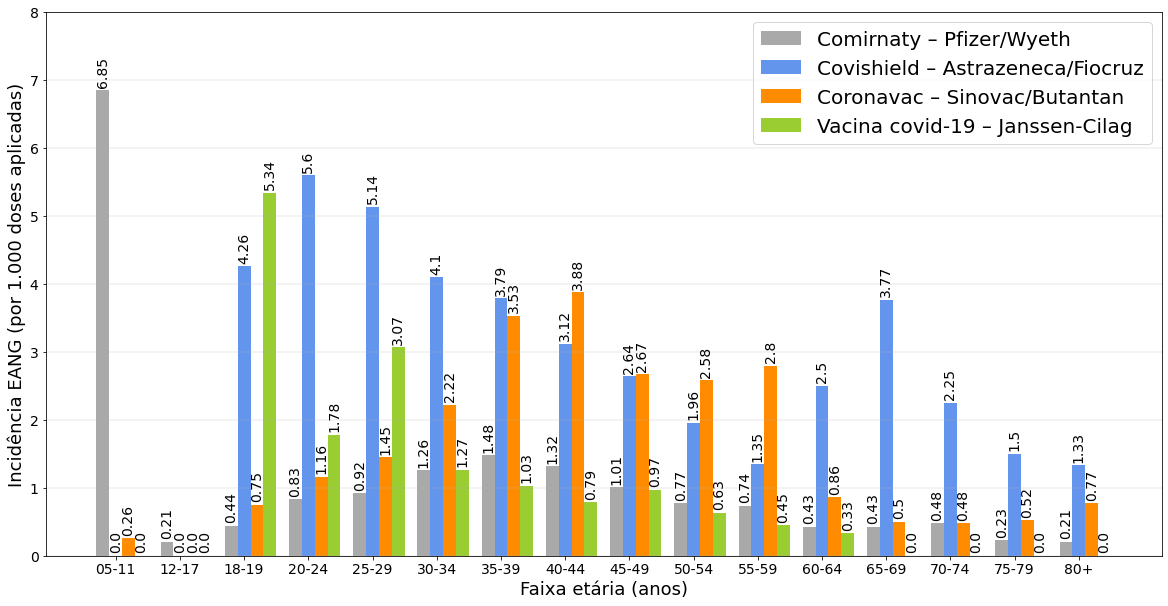

In [24]:
## GRÁFICO ##
diameters = df_faixas_grafico['FAIXAETARIA'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, pfizer_ng['incidencia_1000ds'], width=width, label='Comirnaty – Pfizer/Wyeth', align='center', color='darkgray')
rects2 = ax.bar(x, astrazeneca_ng['incidencia_1000ds'], width=width, label='Covishield – Astrazeneca/Fiocruz', align='center', color='cornflowerblue')
rects3 = ax.bar(x + width, coronavac_ng['incidencia_1000ds'], width=width, label='Coronavac – Sinovac/Butantan', align='center', color='darkorange')
rects4 = ax.bar(x + width*2, janssen_ng['incidencia_1000ds'], width=width, label='Vacina covid-19 – Janssen-Cilag', align='center', color='yellowgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência EANG (por 1.000 doses aplicadas)', fontsize=18)
ax.set_xlabel('Faixa etária (anos)', fontsize=18)
ax.set_xticks(x)
plt.xticks(fontsize=14)
ax.set_xticklabels(diameters)
plt.yticks(fontsize=14)
ax.legend(fontsize=20)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', rotation=90, fontsize=14)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.ylim(0,8)
plt.grid(axis='y', linewidth=0.3)
plt.savefig('Graficos/Figura 8.png', dpi=(800), bbox_inches='tight')
plt.show()

Grave

In [25]:
# EAPV Graves
df_faixas_eapv_g = df_faixas_eapv[df_faixas_eapv['CLASSIFICACAO DE GRAVIDADE']=='Grave']

# Merge EAPV e APLICADAS por faixa etária e por vacina
df_faixas_apl_eapv_g = pd.merge(df_faixas_apl, df_faixas_eapv_g, left_on=['FAIXAETARIA', 'VACINA'], right_on=['FAIXA ETARIA', 'VACINA'], how='outer')
df_faixas_apl_eapv_g = df_faixas_apl_eapv_g[['FAIXAETARIA', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'COUNT', 'eapv']]
df_faixas_apl_eapv_g['eapv'].fillna(0, inplace=True)

# Incidência de EAPV por faixa etária e por vacina por 100 mil doses
df_faixas_apl_eapv_g['incidencia_1000ds'] = round((df_faixas_apl_eapv_g['eapv']/df_faixas_apl_eapv_g['COUNT']*100000),2)

In [26]:
#colocar 'Grave' nos NaN
df_faixas_apl_eapv_g['CLASSIFICACAO DE GRAVIDADE'].fillna('Grave', inplace=True)

In [27]:
# separando vacinas e colocando 0 nas vacinas que não foram aplicadas em 12-17 para não dar erro no gráfico
pfizer_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Pfizer'].reset_index(drop=True)

astrazeneca_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Astrazeneca'].reset_index(drop=True)
astrazeneca_g.at[14]=['12-17', 'Astrazeneca', astrazeneca_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
astrazeneca_g.at[15]=['05-11', 'Astrazeneca', astrazeneca_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
astrazeneca_g = astrazeneca_g.sort_values('FAIXAETARIA').reset_index(drop=True)

coronavac_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Coronavac'].reset_index(drop=True)

janssen_g = df_faixas_apl_eapv_g.loc[df_faixas_apl_eapv_g['VACINA']=='Janssen'].reset_index(drop=True)
janssen_g.at[14]=['12-17', 'Janssen', janssen_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
janssen_g.at[15]=['05-11', 'Janssen', janssen_g['CLASSIFICACAO DE GRAVIDADE'][0], 0, 0, 0]
janssen_g = janssen_g.sort_values('FAIXAETARIA').reset_index(drop=True)

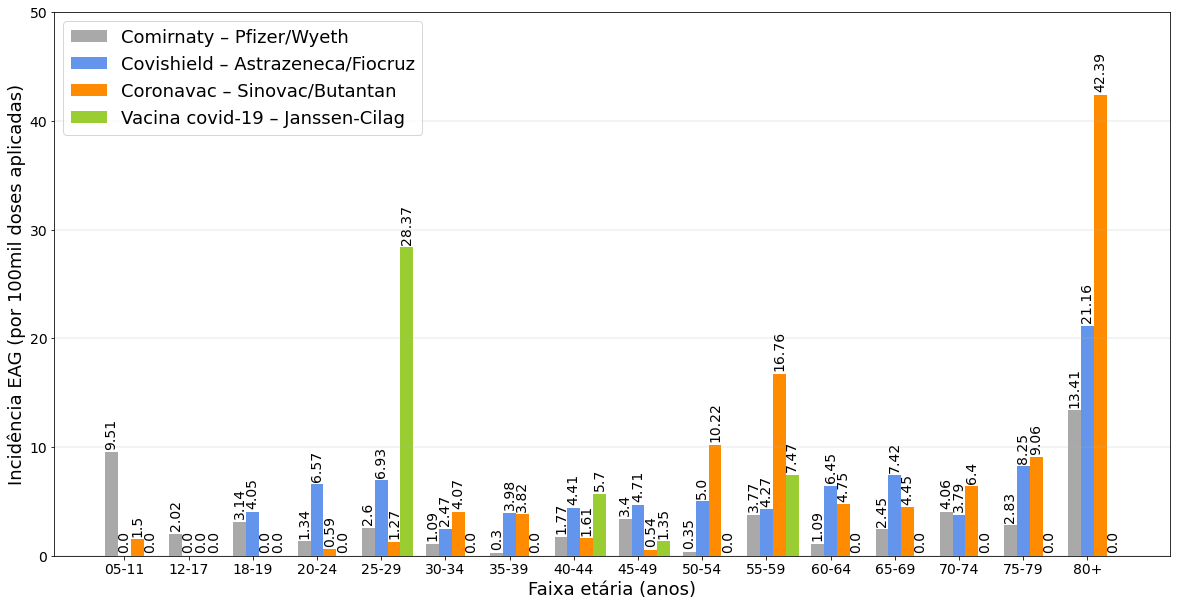

In [28]:
## GRÁFICO ##
diameters = df_faixas_grafico['FAIXAETARIA'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, pfizer_g['incidencia_1000ds'], width=width, label='Comirnaty – Pfizer/Wyeth', align='center', color='darkgray')
rects2 = ax.bar(x, astrazeneca_g['incidencia_1000ds'], width=width, label='Covishield – Astrazeneca/Fiocruz', align='center', color='cornflowerblue')
rects3 = ax.bar(x + width, coronavac_g['incidencia_1000ds'], width=width, label='Coronavac – Sinovac/Butantan', align='center', color='darkorange')
rects4 = ax.bar(x + width*2, janssen_g['incidencia_1000ds'], width=width, label='Vacina covid-19 – Janssen-Cilag', align='center', color='yellowgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência EAG (por 100mil doses aplicadas)', fontsize=18)
ax.set_xlabel('Faixa etária (anos)', fontsize=18)
ax.set_xticks(x)
plt.xticks(fontsize=14)
ax.set_xticklabels(diameters)
plt.yticks(fontsize=14)
ax.legend(fontsize=18)

# adicionar valores na barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', rotation=90, fontsize=14)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.ylim(0,50)
plt.grid(axis='y', linewidth=0.3)
plt.savefig('Graficos/Figura 9.png', dpi=(800), bbox_inches='tight')
plt.show()

A PARTIR DAQUI USAMOS O BANCO COM O NUMERO DE EVENTOS ADVERSOS

In [29]:
df_eventos.shape

(34976, 110)

In [30]:
df_eventos['VACINA'].unique()
# Ajusta nome Butantan para Coronavac
df_eventos['VACINA'] = df_eventos['VACINA'].str.replace('Butantan', 'Coronavac')

POR GRAVIDADE E VACINA

In [31]:
# Distribuição de eventos adversos por gravidade e vacina por 1000 doses
df_eventos_vac_gng = df_eventos[['CLASSIFICACAO DE GRAVIDADE', 'VACINA']]
df_eventos_vac_gng['eventos'] = 1
df_eventos_vac_gng = df_eventos_vac_gng.groupby(by=['VACINA', 'CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()
df_eventos_vac_gng

,VACINA,CLASSIFICACAO DE GRAVIDADE,eventos
0,Astrazeneca,Grave,394
1,Astrazeneca,Não grave,21276
2,Coronavac,Grave,354
3,Coronavac,Não grave,5806
4,Janssen,Grave,15
5,Janssen,Não grave,483
6,Pfizer,Grave,190
7,Pfizer,Não grave,6458


In [32]:
#Total de grave e não grave
df_eventos_vac_gng_graf = df_eventos_vac_gng.groupby(by=['CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()
df_eventos_vac_gng_graf

,CLASSIFICACAO DE GRAVIDADE,eventos
0,Grave,953
1,Não grave,34023


MEDIANA DE IDADE

In [33]:
# MÉDIANA DE IDADE EAG e EANG
df_media_idade = df_eventos[['IDADE EVENTO', 'CLASSIFICACAO DE GRAVIDADE']]
df_media_idade_EAG = df_media_idade[df_media_idade['CLASSIFICACAO DE GRAVIDADE'] == 'Grave']
df_media_idade_EANG = df_media_idade[df_media_idade['CLASSIFICACAO DE GRAVIDADE'] == 'Não grave']

import statistics as sta
#mediana = sta.median(df_media_idade_EAG['IDADE EVENTO'])
#print('Mediana de idade EAG: ', mediana)

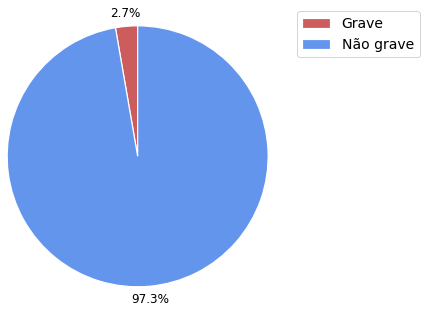

In [34]:
## GRÁFICO ##
colors = ['indianred', 'cornflowerblue']
plt.pie(df_eventos_vac_gng_graf['eventos'], 
        autopct='%1.1f%%',                   #valores em porcentagem
        startangle=90,                       #iniciando no angulo 90
        radius=1.5,                          #tamanho do raio
        textprops={'fontsize': 12},          #tamanho da fonte
        colors=colors,                       #cores
        pctdistance=1.10,                     #distância dos valores
        wedgeprops = {"edgecolor" : "white", #borda
                      'linewidth': 1.2, 
                      'antialiased': True})

plt.legend(df_eventos_vac_gng_graf['CLASSIFICACAO DE GRAVIDADE'], loc=0, bbox_to_anchor=(1.2, 1.2), fontsize=14)

plt.savefig('Graficos/figura 3.png',dpi=(800), bbox_inches='tight')
plt.show()

In [34]:
# Pegar totais aplicados por vacina do df_vacinados
df_apl_por_vacina = df_vacinados[['TP_VACINA', 'COUNT']]
df_apl_por_vacina = df_apl_por_vacina.groupby(by=['TP_VACINA']).sum()
df_apl_por_vacina.reset_index(inplace=True)
df_apl_por_vacina

,TP_VACINA,COUNT
0,Astrazeneca,7275490
1,Coronavac,4628180
2,Janssen,444880
3,Pfizer,8203840


In [35]:
# Inserir totais de vacina na tabela eventos GRAVE x não grave para calculo da taxa
df_eventos_vac_gng_apl = pd.merge(df_eventos_vac_gng, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='left')
df_eventos_vac_gng_apl = df_eventos_vac_gng_apl[['VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'eventos', 'COUNT']]

# Cálculo da Incidência de EAPV GRAVE e NAO GRAVE por vacina por 1000 doses aplicadas
df_eventos_vac_gng_apl['incidencia_1000ds'] = round((df_eventos_vac_gng_apl['eventos'] / df_eventos_vac_gng_apl['COUNT'] * 1000),2)
df_eventos_vac_gng_apl

,VACINA,CLASSIFICACAO DE GRAVIDADE,eventos,COUNT,incidencia_1000ds
0,Astrazeneca,Grave,394,7275490,0.05
1,Astrazeneca,Não grave,21276,7275490,2.92
2,Coronavac,Grave,354,4628180,0.08
3,Coronavac,Não grave,5806,4628180,1.25
4,Janssen,Grave,15,444880,0.03
5,Janssen,Não grave,483,444880,1.09
6,Pfizer,Grave,190,8203840,0.02
7,Pfizer,Não grave,6458,8203840,0.79


In [36]:
# eventos adversos por vacina x gravidade x sexo

# Pegar totais aplicados por vacina do df_vacinados
df_apl_por_sexo

# Distribuição de eventos adversos por gravidade x vacina x sexo por 1000 doses
df_eventos_vac_gng_sex = df_eventos[['SEXO', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']]
df_eventos_vac_gng_sex['eventos'] = 1
df_eventos_vac_gng_sex = df_eventos_vac_gng_sex.groupby(by=['SEXO', 'VACINA', 'CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()

# merge
df_eventos_vac_gng_sex_apl = pd.merge(df_eventos_vac_gng_sex, df_apl_por_sexo, on=['SEXO', 'VACINA'] , how='outer')

# Cálculo da incidência de EAPV por sxo, vacina, gravidade por 1000ds aplicadas
df_eventos_vac_gng_sex_apl['incidencia_1000ds'] = round((df_eventos_vac_gng_sex_apl['eventos'] / df_eventos_vac_gng_sex_apl['COUNT'] * 1000),2)
df_eventos_vac_gng_sex_apl

,SEXO,VACINA,CLASSIFICACAO DE GRAVIDADE,eventos,COUNT,incidencia_1000ds
0,Feminino,Astrazeneca,Grave,206,3792947,0.05
1,Feminino,Astrazeneca,Não grave,16453,3792947,4.34
2,Feminino,Coronavac,Grave,205,2610486,0.08
3,Feminino,Coronavac,Não grave,4615,2610486,1.77
4,Feminino,Janssen,Grave,14,203636,0.07
5,Feminino,Janssen,Não grave,244,203636,1.20
6,Feminino,Pfizer,Grave,111,4382889,0.03
7,Feminino,Pfizer,Não grave,4833,4382889,1.10
8,Masculino,Astrazeneca,Grave,188,3482543,0.05
9,Masculino,Astrazeneca,Não grave,4823,3482543,1.38


# CASOS

# Gestantes

In [38]:
### VACINAS APLICADAS EM GESTANTES ###
# Ver numero de aplicadas em gestantes no RS
df_gestantes = df_vacinados[df_vacinados['DETALHEGRUPO'] == 'Gestante']
df_gestantes = df_gestantes[['DOSE', 'TP_VACINA']]
print(df_gestantes.shape)

# Gestantes x tipo de vacina aplicada
gestantes_vacina = pd.pivot_table(df_gestantes, values='DOSE', index=['TP_VACINA'], aggfunc='count').reset_index()
gestantes_vacina

(76685, 2)


,TP_VACINA,DOSE
0,Astrazeneca,7698
1,Coronavac,5149
2,Janssen,49
3,Pfizer,63789


In [39]:
### EAPV EM GESTANTES ###
eapv_gestantes = data_eapv[data_eapv['GESTANTE NO MOMENTO DA VACINACAO?'] == 'Sim']
eapv_gestantes = eapv_gestantes[['NUMERO DA NOTIFICACAO', 'IDADE EVENTO', 'MUNICIPIO DE RESIDENCIA', 'NOME COMPLETO', 
                                 'DOSE', 'DATA DA APLICACAO', 'DESCRICAO DO CASO', 'REACAO / EVENTO ADVERSO',
                                 'CODIGO EVENTO ADVERSO', 'DATA DE INICIO', 'TIPO DE EVENTO', 'CLASSIFICACAO DE GRAVIDADE', 'GRAVIDADE',
                                 'DESFECHO (EVOLUCAO DO CASO)', 'DATA DESFECHO', 'DOENCAS (CID10)',
                                 'DESCRICAO DETALHADA DO EVENTO ADVERSO', 'HOUVE ATENDIMENTO MEDICO?', 'TIPO DE ATENDIMENTO', 
                                 'OBSERVACOES COMPLEMENTARES', 'NOME DO EXAME', 'RESULTADO DO EXAME',
                                 'DATA DA REALIZACAO DO EXAME', 'FAIXA ETARIA', 
                                 'NOME_EXAME', 'RESULTADO_EXAME', 'COVID_POSITIVO', 'OBITO', 'VACINA']]

# Mediana de idade GESTANTES com EAPV
mediana_gestantes = eapv_gestantes['IDADE EVENTO'].median()
mediana_gestantes_graves = eapv_gestantes[eapv_gestantes['CLASSIFICACAO DE GRAVIDADE'].str.contains('Grave')]['IDADE EVENTO'].median()
mediana_gestantes_naograves = eapv_gestantes[eapv_gestantes['CLASSIFICACAO DE GRAVIDADE'].str.contains('Não')]['IDADE EVENTO'].median()
print(f'Mediana de idade das gestantes: {mediana_gestantes}')
print(f'Mediana de idade das gestantes com eventos Graves: {mediana_gestantes_graves}')
print(f'Mediana de idade das gestantes com eventos Não graves: {mediana_gestantes_naograves}')

Mediana de idade das gestantes: 30.0
Mediana de idade das gestantes com eventos Graves: 28.5
Mediana de idade das gestantes com eventos Não graves: 30.0


In [40]:
# Gestantes x EAPV por tipo de vacina aplicada e gravidade
eapv_gestantes_vacina = pd.pivot_table(eapv_gestantes, values='NUMERO DA NOTIFICACAO', index=['VACINA', 'CLASSIFICACAO DE GRAVIDADE'], aggfunc='count').reset_index()

# Merge com aplicadas:
eapv_gestantes_vacina = pd.merge(eapv_gestantes_vacina, gestantes_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer' )

eapv_gestantes_vacina = eapv_gestantes_vacina[['TP_VACINA', 'CLASSIFICACAO DE GRAVIDADE', 'NUMERO DA NOTIFICACAO', 'DOSE']]
eapv_gestantes_vacina.rename(columns={'TP_VACINA': 'vacina', 'CLASSIFICACAO DE GRAVIDADE': 'gravidade', 'NUMERO DA NOTIFICACAO': 'EAPV', 'DOSE': 'aplicadas'}, inplace=True)

# Incidência de EAPV em gestantes vacinadas por 1000 doses aplicadas
eapv_gestantes_vacina['incidencia'] = (eapv_gestantes_vacina['EAPV'] / eapv_gestantes_vacina['aplicadas'] * 1000).round(2)

eapv_gestantes_vacina.fillna(0, inplace=True)
eapv_gestantes_vacina

,vacina,gravidade,EAPV,aplicadas,incidencia
0,Astrazeneca,Grave,5.0,7698,0.65
1,Astrazeneca,Não grave,151.0,7698,19.62
2,Coronavac,Não grave,21.0,5149,4.08
3,Pfizer,Grave,7.0,63789,0.11
4,Pfizer,Não grave,52.0,63789,0.82
5,Janssen,0,0.0,49,0.00


In [41]:
eapv_gest_vac = eapv_gestantes_vacina.groupby(by=['vacina', 'aplicadas']).sum().reset_index()
eapv_gest_vac['incidencia'] = (eapv_gest_vac['EAPV'] / eapv_gest_vac['aplicadas'] * 1000).round(2)
eapv_gest_vac

,vacina,aplicadas,EAPV,incidencia
0,Astrazeneca,7698,156.0,20.27
1,Coronavac,5149,21.0,4.08
2,Janssen,49,0.0,0.00
3,Pfizer,63789,59.0,0.92


In [42]:
## Total de eventos em gestantes e gravidade x taxa de incidência por 1000 doses
total_eapv_incid = pd.pivot_table(eapv_gestantes_vacina, values='EAPV', index=['gravidade'], aggfunc='sum').reset_index()
total_eapv_incid['incidencia'] = (total_eapv_incid['EAPV'] / 41527 *1000).round(2)
total_eapv_incid = total_eapv_incid[~(total_eapv_incid['gravidade'] == 0)]
total_eapv_incid

,gravidade,EAPV,incidencia
1,Grave,12.0,0.29
2,Não grave,224.0,5.39


# Guillain Barre

In [37]:
## GUILLAIN BARRE ##
# O arquivo usando na pesquisa por GB não é a base separada por evento. 
# Solução temporária: transformar os numeros de notificação em uma lista e pesquisar no df_eventos e usar o retorno
# Problema: tem 'nan' - excluido os nan do excel

# Ler arquivo conferido de Guillain Barre
df_guillain = pd.read_excel('Casos/guillain_barre_boletim_01_2022.xlsx')
df_guillain_final = df_guillain.copy()
# Lista dos GB
lista_df_guillain_final = df_guillain_final['Número da Notificação'].astype(str).to_list()

# Pesquisar os números no df_eventos
df_guillain_final = df_eventos[df_eventos['NUMERO DA NOTIFICACAO'].astype(str).str.contains('(?i)' + '|'.join(lista_df_guillain_final), na=False)]

# Ficar somente com os números de notificação únicos
df_guillain_final.drop_duplicates(subset=['NUMERO DA NOTIFICACAO'], inplace=True)

df_guillain_final = df_guillain_final[['NUMERO DA NOTIFICACAO', 'VACINA', 'IDADE EVENTO']]
df_guillain_tabela = df_guillain_final.copy()
df_guillain_final = df_guillain_final.groupby(['VACINA']).count().reset_index()

# Merge com aplicadas por vacina:
df_guillain_final = pd.merge(df_guillain_final, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer')
df_guillain_final.rename(columns={'NUMERO DA NOTIFICACAO': 'n Guillain'}, inplace=True)
df_guillain_final = df_guillain_final[['VACINA', 'COUNT', 'n Guillain']]
df_guillain_final.rename(columns={'COUNT': 'aplicadas'}, inplace=True)
df_guillain_final

# Incidência de Guillain por vacina
df_guillain_final['incidencia_100mil_ds'] = ((df_guillain_final['n Guillain'] / df_guillain_final['aplicadas']) *100000).round(2)
df_guillain_final

,VACINA,aplicadas,n Guillain,incidencia_100mil_ds
0,Astrazeneca,7275490,12,0.16
1,Coronavac,4628180,4,0.09
2,Janssen,444880,2,0.45
3,Pfizer,8203840,1,0.01


Mediana e idade minima e máxima por vacina 

In [38]:
# Atrazeneca
astrazeneca = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Astrazeneca']
mediana_astrazeneca = astrazeneca['IDADE EVENTO'].median()
menor_astrazeneca = min(astrazeneca['IDADE EVENTO']) 
maior_astrazeneca = max(astrazeneca['IDADE EVENTO'])
print(f'Astrazeneca | Mediana', mediana_astrazeneca, 'Intervalo (anos)',menor_astrazeneca,'-',maior_astrazeneca)

# Coronavac
coronavac = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Coronavac']
mediana_coronavac = coronavac['IDADE EVENTO'].median()
menor_coronavac = min(coronavac['IDADE EVENTO']) 
maior_coronavac = max(coronavac['IDADE EVENTO'])
print(f'Coronavac | Mediana', mediana_coronavac, 'Intervalo (anos)',menor_coronavac,'-',maior_coronavac)

# Janssen
janssen = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Janssen']
mediana_janssen = janssen['IDADE EVENTO'].median()
menor_janssen = min(janssen['IDADE EVENTO']) 
maior_janssen = max(janssen['IDADE EVENTO'])
print(f'Janssen | Mediana', mediana_janssen, 'Intervalo (anos)',menor_janssen,'-',maior_janssen)

# Pfizer
pfizer = df_guillain_tabela[df_guillain_tabela['VACINA']== 'Pfizer']
mediana_pfizer = pfizer['IDADE EVENTO'].median()
menor_pfizer = min(pfizer['IDADE EVENTO']) 
maior_pfizer = max(pfizer['IDADE EVENTO'])
print(f'Pfizer | Mediana', mediana_pfizer, 'Intervalo (anos)',menor_pfizer,'-',maior_pfizer)

Astrazeneca | Mediana 43.0 Intervalo (anos) 26 - 56
Coronavac | Mediana 65.0 Intervalo (anos) 25 - 71
Janssen | Mediana 46.0 Intervalo (anos) 43 - 49
Pfizer | Mediana 23.0 Intervalo (anos) 23 - 23


Valores total

In [39]:
# Mediana de idade
mediana_guillain_barre = df_guillain['Idade Evento'].median()
print(f'Mediana', mediana_guillain_barre)
# Incidencia geral GB por 100mil doses aplicadas
incid_gb = ((df_guillain_final['n Guillain'].sum() / df_guillain_final['aplicadas'].sum())*100000).round(2)
print(f'Incidencia', incid_gb)
# Idade max e min
menor_gb = min(df_guillain['Idade Evento']) 
maior_gb = max(df_guillain['Idade Evento'])
print(f'Intervalo (anos)',menor_gb,'-',maior_gb)

Mediana 45.5
Incidencia 0.09
Intervalo (anos) 23 - 80


Casos encerrados

In [40]:
# Casos encerrados
df_guillain_encerradas = df_guillain[(df_guillain['Encerramento Municipal - Causalidade'].notna()) | (df_guillain['Encerramento Estadual - Causalidade'].notna()) | 
   (df_guillain['Encerramento Federal - Causalidade'].notna()) | (df_guillain['Encerramento Cifavi - Causalidade'].notna())]
# Filtrando colunas
df_guillain_encerradas = df_guillain_encerradas[['Número da Notificação', 'Encerramento Municipal - Causalidade', 
                                                'Encerramento Estadual - Causalidade', 'Encerramento Federal - Causalidade', 'Encerramento Cifavi - Causalidade']]

df_guillain_encerradas

,Número da Notificação,Encerramento Municipal - Causalidade,Encerramento Estadual - Causalidade,Encerramento Federal - Causalidade,Encerramento Cifavi - Causalidade
7,1432100141894,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN,NaN
11,1432100159890,NaN,1: B2 – Os dados da investigação são conflitan...,NaN,NaN
17,1432100132852,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN,NaN
18,1432100133392,NaN,1: B2 – Os dados da investigação são conflitan...,NaN,NaN


# Trombose

In [41]:
# Puxar banco completo
df_tromboses = pd.read_excel('Casos/trombose_boletim_01_2022.xlsx')
df_trombose_completo = df_tromboses.copy()
df_tromboses = df_tromboses[['Imunobiológico (vacina)', 'Idade Evento', 'Sexo', 'CLASSIFICAÇÃO']]
df_tromboses['n Tromboses'] = 1
print(f'Total: {df_tromboses.shape[0]}')

# Tratando nome das vacinas
df_tromboses.loc[df_tromboses['Imunobiológico (vacina)'].str.contains('(?i)' + 'sinovac|coronavac|butantan'), 'Imunobiológico (vacina)'] = 'Coronavac'
df_tromboses.loc[df_tromboses['Imunobiológico (vacina)'].str.contains('(?i)' + 'astrazeneca|covishield|fiocruz|oxford|1: SARC', na=False), 'Imunobiológico (vacina)'] = 'Astrazeneca'
df_tromboses.loc[df_tromboses['Imunobiológico (vacina)'].str.contains('(?i)janssen', na=False), 'Imunobiológico (vacina)'] = 'Janssen'
df_tromboses.loc[df_tromboses['Imunobiológico (vacina)'].str.contains('(?i)pfizer', na=False), 'Imunobiológico (vacina)'] = 'Pfizer'
df_tromboses.rename(columns={'Imunobiológico (vacina)': 'VACINA'}, inplace=True)

Total: 128


In [42]:
df_tromboses_vac = df_tromboses.copy()
df_tromboses_vac = df_tromboses_vac.groupby(['VACINA']).count().reset_index()
# Merge com aplicadas por vacina:
df_tromboses_vac = pd.merge(df_tromboses_vac, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer')
df_tromboses_vac.rename(columns={'COUNT': 'aplicadas'}, inplace=True)
df_tromboses_vac = df_tromboses_vac[['VACINA', 'aplicadas', 'n Tromboses']]
## INCIDÊNCIA POR VACINA
df_tromboses_vac['incidencia_100mil_ds'] = ((df_tromboses_vac['n Tromboses'] / df_tromboses_vac['aplicadas']) *100000).round(2)
df_tromboses_vac

,VACINA,aplicadas,n Tromboses,incidencia_100mil_ds
0,Astrazeneca,7275490,95,1.31
1,Coronavac,4628180,13,0.28
2,Janssen,444880,2,0.45
3,Pfizer,8203840,18,0.22


In [43]:
# Variaveis com valores de vacinas
aplicadas_astra = df_tromboses_vac['aplicadas'].iloc[0]
aplicadas_corona = df_tromboses_vac['aplicadas'].iloc[1]
aplicadas_janssen = df_tromboses_vac['aplicadas'].iloc[2]
aplicadas_pfizer = df_tromboses_vac['aplicadas'].iloc[3]
total_aplicados = df_tromboses_vac['aplicadas'].sum()

In [44]:
## POR CLASSIFICAÇÃO
df_trombose_classificado = df_tromboses.copy()
# Groupby
df_trombose_classificado = df_trombose_classificado[['CLASSIFICAÇÃO', 'VACINA', 'n Tromboses']]
df_trombose_classificado = df_trombose_classificado.groupby(by=['VACINA', 'CLASSIFICAÇÃO']).count().reset_index()
# Merge
df_trombose_classificado = pd.merge(df_trombose_classificado, df_apl_por_vacina, left_on='VACINA', right_on='TP_VACINA', how='outer')
df_trombose_classificado.rename(columns={'COUNT': 'aplicadas'}, inplace=True)
df_trombose_classificado = df_trombose_classificado[['CLASSIFICAÇÃO', 'n Tromboses', 'VACINA', 'aplicadas']]
# Incidência
df_trombose_classificado['incidencia_100mil_ds'] = ((df_trombose_classificado['n Tromboses'] / df_trombose_classificado['aplicadas']) *100000).round(2)
df_trombose_classificado

,CLASSIFICAÇÃO,n Tromboses,VACINA,aplicadas,incidencia_100mil_ds
0,AVC,11,Astrazeneca,7275490,0.15
1,PT,2,Astrazeneca,7275490,0.03
2,TEP,9,Astrazeneca,7275490,0.12
3,Tromboflebite,13,Astrazeneca,7275490,0.18
4,Trombose,60,Astrazeneca,7275490,0.82
5,AVC,3,Coronavac,4628180,0.06
6,IAM,1,Coronavac,4628180,0.02
7,PT,1,Coronavac,4628180,0.02
8,TEP,2,Coronavac,4628180,0.04
9,Tromboflebite,1,Coronavac,4628180,0.02


In [45]:
df_classificacao_total = df_trombose_classificado.copy()
df_classificacao_total = df_classificacao_total[['CLASSIFICAÇÃO', 'n Tromboses']]
df_classificacao_total = df_classificacao_total.groupby(by=['CLASSIFICAÇÃO']).sum().reset_index()
# Incidência
df_classificacao_total['incidencia_100mil_ds'] = ((df_classificacao_total['n Tromboses'] / total_aplicados) *100000).round(2)
df_classificacao_total

,CLASSIFICAÇÃO,n Tromboses,incidencia_100mil_ds
0,AVC,14,0.07
1,IAM,1,0.00
2,PT,5,0.02
3,TEP,13,0.06
4,Tromboflebite,15,0.07
5,Trombose,80,0.39


In [46]:
## MEDIANA DE IDADE
# opção: usar o crosstab (mediana por classificação)
df_tromboses_mediana = df_tromboses.copy()
df_tromboses_mediana = df_tromboses_mediana[['CLASSIFICAÇÃO', 'Idade Evento']]

avc_idade_min =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'AVC']['Idade Evento'].min()
avc_idade_max =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'AVC']['Idade Evento'].max()
avc_idade_mediana =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'AVC']['Idade Evento'].median()

iam_idade_min =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'IAM']['Idade Evento'].min()
iam_idade_max =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'IAM']['Idade Evento'].max()
iam_idade_mediana =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'IAM']['Idade Evento'].median()

pt_idade_min =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'PT']['Idade Evento'].min()
pt_idade_max =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'PT']['Idade Evento'].max()
pt_idade_mediana =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'PT']['Idade Evento'].median()

tep_idade_min =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'TEP']['Idade Evento'].min()
tep_idade_max =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'TEP']['Idade Evento'].max()
tep_idade_mediana =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'TEP']['Idade Evento'].median()

tromboflebite_idade_min =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'Tromboflebite']['Idade Evento'].min()
tromboflebite_idade_max =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'Tromboflebite']['Idade Evento'].max()
tromboflebite_idade_mediana =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'Tromboflebite']['Idade Evento'].median()

trombose_idade_min =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'Trombose']['Idade Evento'].min()
trombose_idade_max =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'Trombose']['Idade Evento'].max()
trombose_idade_mediana =  df_tromboses_mediana.loc[df_tromboses_mediana['CLASSIFICAÇÃO'] == 'Trombose']['Idade Evento'].median()

In [47]:
idades_min = [avc_idade_min, iam_idade_min, pt_idade_min, tep_idade_min, tromboflebite_idade_min, trombose_idade_min]
idades_max = [avc_idade_max, iam_idade_max, pt_idade_max, tep_idade_max, tromboflebite_idade_max, trombose_idade_max]
idades_mediana = [avc_idade_mediana, iam_idade_mediana, pt_idade_mediana, tep_idade_mediana, tromboflebite_idade_mediana, trombose_idade_mediana]

In [48]:
df_tromboses_mediana = df_tromboses_mediana.groupby('CLASSIFICAÇÃO').count().reset_index()

In [55]:
# corrigir idade mínima = 0
# fazer grafico pizza

In [49]:
df_tromboses_mediana['IDADE MINIMA'] = idades_min
df_tromboses_mediana['IDADE MAXIMA'] = idades_max
df_tromboses_mediana['IDADE MEDIANA'] = idades_mediana

df_tromboses_mediana['IDADE MEDIANA'] = df_tromboses_mediana['IDADE MEDIANA'].apply(round)
df_tromboses_mediana = df_tromboses_mediana.rename(columns={'Idade Evento':'COUNT'})
df_tromboses_mediana

,CLASSIFICAÇÃO,COUNT,IDADE MINIMA,IDADE MAXIMA,IDADE MEDIANA
0,AVC,14,20,84,62
1,IAM,1,65,65,65
2,PT,5,14,66,37
3,TEP,13,48,93,61
4,Tromboflebite,15,32,70,51
5,Trombose,80,16,91,50


In [50]:
# insere linha com total e calcula os totais com base nas colunas originais do dataframe
total = ['Total']
total.append(df_tromboses_mediana['COUNT'].sum())
total.append(df_tromboses['Idade Evento'].min())
total.append(df_tromboses['Idade Evento'].max())
total.append(df_tromboses['Idade Evento'].median())

df_tromboses_mediana.at[6] = total

In [51]:
#Transforma as colunas float em int
colunas = df_tromboses_mediana.select_dtypes(include=float).columns
df_tromboses_mediana[colunas]  = df_tromboses_mediana[colunas].astype(int)

In [52]:
df_tromboses_mediana

,CLASSIFICAÇÃO,COUNT,IDADE MINIMA,IDADE MAXIMA,IDADE MEDIANA
0,AVC,14,20,84,62
1,IAM,1,65,65,65
2,PT,5,14,66,37
3,TEP,13,48,93,61
4,Tromboflebite,15,32,70,51
5,Trombose,80,16,91,50
6,Total,128,14,93,52


In [53]:
## ENCERRADOS
df_trombose_encerrados = df_trombose_completo.copy()
df_trombose_encerrados = df_trombose_encerrados[(df_trombose_encerrados['Encerramento Municipal - Causalidade'].notna()) | 
                        (df_trombose_encerrados['Encerramento Estadual - Causalidade'].notna()) | 
                        (df_trombose_encerrados['Encerramento Federal - Causalidade'].notna()) | 
                        (df_trombose_encerrados['Encerramento Cifavi - Causalidade'].notna())]

# Filtrando colunas
df_trombose_encerrados = df_trombose_encerrados[['Número da Notificação', 
                                                'Encerramento Municipal - Causalidade', 
                                                'Encerramento Estadual - Causalidade', 
                                                'Encerramento Federal - Causalidade']]

#colunas = ['Número da Notificação','Encerramento Municipal - Causalidade','Encerramento Estadual - Causalidade','Encerramento Federal - Causalidade']
#df_trombose_encerrados = df_trombose_encerrados.loc[df_trombose_encerrados.colunas] == 'Reações inerentes ao produto, conforme literatura'

In [54]:
# encontrar uma forma de fazer o count da classificação do encerramento
# no momento, contar um por um

In [55]:
df_trombose_encerrados

,Número da Notificação,Encerramento Municipal - Causalidade,Encerramento Estadual - Causalidade,Encerramento Federal - Causalidade
0,1432100165734,NaN,1: C - Inconsistente ou coincidente,NaN
3,1432100173660,NaN,1: B2 – Os dados da investigação são conflitan...,NaN
21,1432100137774,NaN,1: B2 – Os dados da investigação são conflitan...,NaN
24,1432100139394,NaN,"1: A.1- Reações inerentes ao produto, conforme...",NaN
27,1432100140070,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN
29,1432100141327,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN
33,1432100143272,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN
40,1432100151296,1: B2 – Os dados da investigação são conflitan...,NaN,NaN
50,1432100157857,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN
56,1432100114131,NaN,"1: B1 – Relação temporal consistente, mas sem ...",NaN


In [56]:
# Grafico trombose
#Percentual de EAPV por sexo
df_tromboses_sexo = df_tromboses[['Sexo']]
df_tromboses_sexo['Total'] = 1
df_tromboses_sexo = df_tromboses_sexo.groupby(by=['Sexo']).count().reset_index()
df_tromboses_sexo

,Sexo,Total
0,Feminino,83
1,Masculino,45


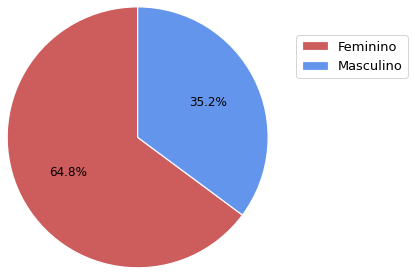

In [57]:
colors = ['indianred', 'cornflowerblue']
plt.pie(df_tromboses_sexo['Total'], autopct='%1.1f%%', startangle = 90, colors=colors, radius=1.5, textprops={'fontsize': 12},
       wedgeprops = {"edgecolor" : "white", #borda
                      'linewidth': 1.2, 
                      'antialiased': True})
plt.legend(df_tromboses_sexo['Sexo'], loc=0, bbox_to_anchor=(1.2, 1), fontsize=13)
plt.savefig('Graficos/figura 11.png',dpi=(800), bbox_inches='tight')
plt.show()

In [63]:
# NOVAS ANÁLISES EM CONSTRUÇÃO
# Raca/cor ainda precisa de alguns ajustes
# Medicamento não esta sendo filtrado na hora de gerar os arquivos

# Raça/cor

In [64]:
df_eventos['RACA/COR'].unique()

array(['Branca', 'Parda', 'Ignorado', 'Preta', 'Amarela', 'Indigena'],
      dtype=object)

In [65]:
df_raca = df_eventos.copy()

In [66]:
# total aplicadas por RACA/COR e TP VACINAS
# incidencia = total de EAPV POR RACA E VACINA / total aplicadas por raca e vacina

In [67]:
# total
df_raca_total = df_raca[['RACA/COR', 'VACINA']]
df_raca_total['TOTAL'] = 1
df_raca_total = df_raca_total.groupby(by=['RACA/COR', 'VACINA']).sum().reset_index()

# incidencia
df_raca_total['incidencia_100000ds'] = round((df_raca_total['TOTAL']/total_aplicadas*100000),2)
df_raca_total

,RACA/COR,VACINA,TOTAL,incidencia_100000ds
0,Amarela,Astrazeneca,11,0.05
1,Amarela,Pfizer,9,0.04
2,Branca,Astrazeneca,17940,87.29
3,Branca,Coronavac,5213,25.36
4,Branca,Janssen,405,1.97
5,Branca,Pfizer,5047,24.56
6,Ignorado,Astrazeneca,1848,8.99
7,Ignorado,Coronavac,284,1.38
8,Ignorado,Janssen,28,0.14
9,Ignorado,Pfizer,767,3.73


In [68]:
# por gravidade
df_raca_gravidade = df_raca[['RACA/COR', 'CLASSIFICACAO DE GRAVIDADE']]
df_raca_gravidade['COUNT'] = 1
df_raca_gravidade = df_raca_gravidade.groupby(by=['RACA/COR', 'CLASSIFICACAO DE GRAVIDADE']).sum().reset_index()
# incidencia
df_raca_gravidade['incidencia_100000ds'] = round((df_raca_gravidade['COUNT']/total_aplicadas*100000),2)
df_raca_gravidade

,RACA/COR,CLASSIFICACAO DE GRAVIDADE,COUNT,incidencia_100000ds
0,Amarela,Não grave,20,0.10
1,Branca,Grave,857,4.17
2,Branca,Não grave,27748,135.01
3,Ignorado,Grave,19,0.09
4,Ignorado,Não grave,2908,14.15
5,Indigena,Não grave,44,0.21
6,Parda,Grave,34,0.17
7,Parda,Não grave,1650,8.03
8,Preta,Grave,43,0.21
9,Preta,Não grave,1653,8.04


In [69]:
# por vacina
df_raca_vac = df_raca[['VACINA', 'RACA/COR']]
df_raca_vac['COUNT_RACA'] = 1
df_raca_vac = df_raca_vac.groupby(by=['RACA/COR', 'VACINA']).sum().reset_index()

df_vac_apl = df_eapv_apl_vac[['VACINA', 'COUNT']]
df_raca_vac = df_raca_vac.merge(df_vac_apl, left_on=['VACINA'], right_on=['VACINA'],
                                how='left')

# incidencia
df_raca_vac['incidencia_100000ds'] = round((df_raca_vac['COUNT_RACA']/df_raca_vac['COUNT']*100000),2)
df_raca_vac

,RACA/COR,VACINA,COUNT_RACA,COUNT,incidencia_100000ds
0,Amarela,Astrazeneca,11,7275490,0.15
1,Amarela,Pfizer,9,8203840,0.11
2,Branca,Astrazeneca,17940,7275490,246.58
3,Branca,Coronavac,5213,4628180,112.64
4,Branca,Janssen,405,444880,91.04
5,Branca,Pfizer,5047,8203840,61.52
6,Ignorado,Astrazeneca,1848,7275490,25.40
7,Ignorado,Coronavac,284,4628180,6.14
8,Ignorado,Janssen,28,444880,6.29
9,Ignorado,Pfizer,767,8203840,9.35


In [70]:
# Seprando por vacina e ajustando índices
pfizer_raca = df_raca_vac.loc[df_raca_vac['VACINA']=='Pfizer'].reset_index(drop=True)
astra_raca = df_raca_vac.loc[df_raca_vac['VACINA']=='Astrazeneca'].reset_index(drop=True)
corona_raca = df_raca_vac.loc[df_raca_vac['VACINA']=='Coronavac'].reset_index(drop=True)
corona_raca.at[5]=['Amarela', 'Coronavac', 0, 0, 0]
janssen_raca = df_raca_vac.loc[df_raca_vac['VACINA']=='Janssen'].reset_index(drop=True)
janssen_raca.at[4]=['Indigena', 'Janssen', 0, 0, 0]
janssen_raca.at[5]=['Amarela', 'Janssen', 0, 0, 0]

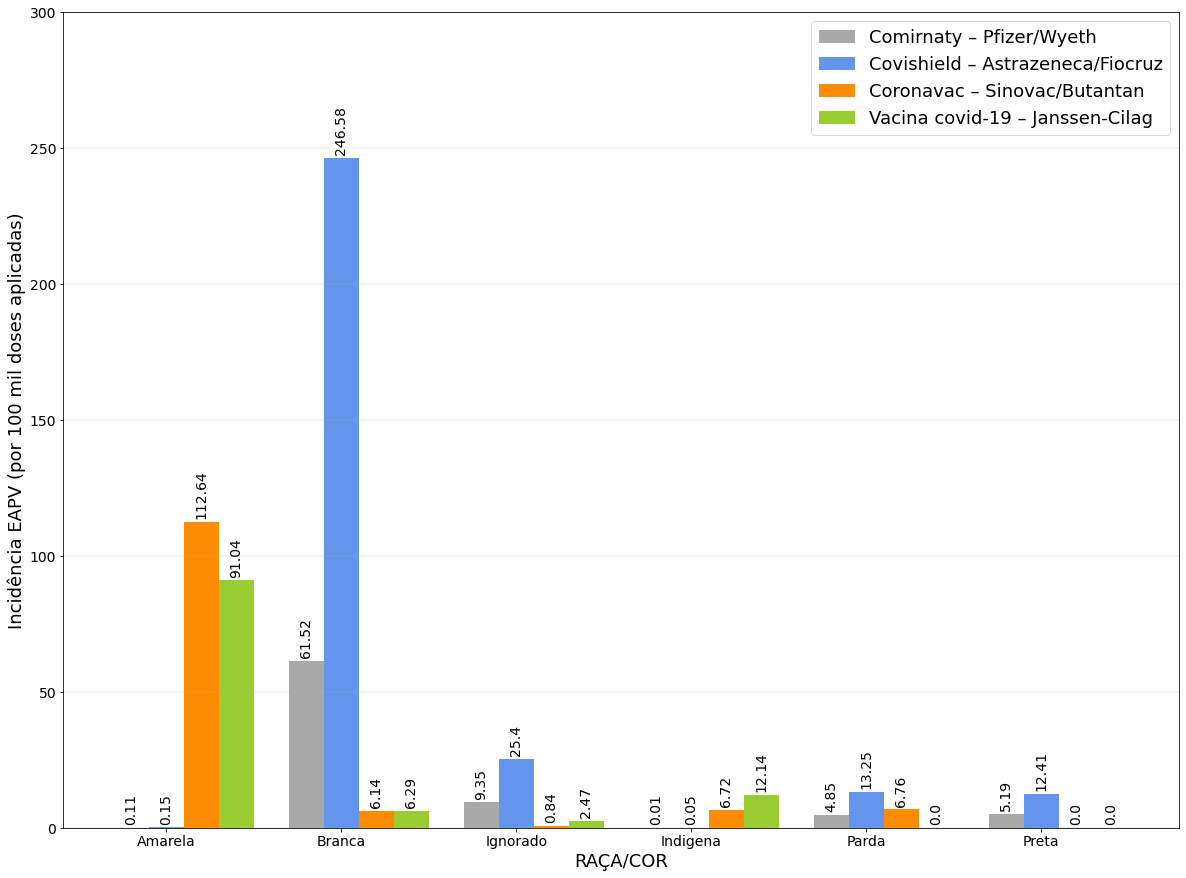

In [71]:
## GRÁFICO POR VACINA
diameters = df_raca_vac['RACA/COR'].unique()

width = 0.2
x = np.arange(len(diameters))

fig, ax = plt.subplots(figsize=(20,15))
rects1 = ax.bar(x - width, pfizer_raca['incidencia_100000ds'], width=width, label='Comirnaty – Pfizer/Wyeth', align='center', color='darkgray')
rects2 = ax.bar(x, astra_raca['incidencia_100000ds'], width=width, label='Covishield – Astrazeneca/Fiocruz', align='center', color='cornflowerblue')
rects3 = ax.bar(x + width, corona_raca['incidencia_100000ds'], width=width, label='Coronavac – Sinovac/Butantan', align='center', color='darkorange')
rects4 = ax.bar(x + width*2, janssen_raca['incidencia_100000ds'], width=width, label='Vacina covid-19 – Janssen-Cilag', align='center', color='yellowgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Incidência EAPV (por 100 mil doses aplicadas)', fontsize=18)
ax.set_xlabel('RAÇA/COR', fontsize=18)
ax.set_xticks(x)
plt.xticks(fontsize=14)
ax.set_xticklabels(diameters)
plt.yticks(fontsize=14)
ax.legend(fontsize=18)

# adicionar valores na barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', rotation=90, fontsize=14)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.ylim(0,300)
plt.grid(axis='y', linewidth=0.3)
plt.savefig('Graficos/Figura NOVA 1.png', dpi=(800), bbox_inches='tight')
plt.show()

# Medicamentos

In [72]:
df_med =  df_eventos[['MEDICAMENTO EM USO ANTERIOR OU DURANTE A VACINACAO','NOME DO MEDICAMENTO',
            'RELACAO DO MEDICAMENTO AO EVENTO ADVERSO','COMENTARIO SOBRE O USO']]


In [73]:
df_med.dropna()
# por algum motivo todos os valores estão nulos


,MEDICAMENTO EM USO ANTERIOR OU DURANTE A VACINACAO,NOME DO MEDICAMENTO,RELACAO DO MEDICAMENTO AO EVENTO ADVERSO,COMENTARIO SOBRE O USO
0,Sim,1: NIMESULIDA | 2: DIPIRONA SODICA | 3: VONAU,1: Concomitante | 2: Concomitante | 3: Concomi...,1: RECEITADO POR 5 DIAS | 2: RECEITADO SN | 3:...
1,Sim,1: NIMESULIDA | 2: DIPIRONA SODICA | 3: VONAU,1: Concomitante | 2: Concomitante | 3: Concomi...,1: RECEITADO POR 5 DIAS | 2: RECEITADO SN | 3:...
2,Sim,1: NIMESULIDA | 2: DIPIRONA SODICA | 3: VONAU,1: Concomitante | 2: Concomitante | 3: Concomi...,1: RECEITADO POR 5 DIAS | 2: RECEITADO SN | 3:...
15,Sim,1: PARACETAMOL | 2: DIPIRONA SODICA,1: Concomitante | 2: Concomitante,1: RECEITADO SN | 2: RECEITADO SN
16,Sim,1: PARACETAMOL | 2: DIPIRONA SODICA,1: Concomitante | 2: Concomitante,1: RECEITADO SN | 2: RECEITADO SN
...,...,...,...,...
34943,Sim,1: OLMESARTANA MEDOXOMICA 40 MG | 2: HCTZA 12....,1: Suspeito | 2: Suspeito,|
34958,Sim,"1: Ebix 20 mg, aas 100 mg, zolpidem 10 mg, ris...",1: Concomitante,1: uso contínuo
34959,Sim,"1: Ebix 20 mg, aas 100 mg, zolpidem 10 mg, ris...",1: Concomitante,1: uso contínuo
34960,Sim,"1: Ebix 20 mg, aas 100 mg, zolpidem 10 mg, ris...",1: Concomitante,1: uso contínuo


In [74]:
# FAZER NOVOS ANÁLISES:
# Raça/ cor 
# Medicamentos